In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [8]:
FILE_PATH = "./datasets/Metro Area Dataset - Income by Metro Area.csv"

# These weights can be adjusted based on the ***importance*** of each feature and must total to 1.0
WEIGHTS = {"median_income": 0.4, "high_earner_percent": 0.4, "log_population": 0.2}


In [9]:
def load_and_clean_data(file_path):
    """
    Loads the dataset from a CSV file, renames columns for easier access,
    and handles missing or invalid data.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        pandas.DataFrame: A cleaned and prepared DataFrame.
    """
    print("Loading and cleaning data...")
    df = pd.read_csv(file_path)

    # Define a mapping for renaming long column names to simpler ones
    column_rename_map = {
        "Geographic Area Name": "metro_area",
        "Population": "population",
        "Households - Median income (dollars)": "median_income",
        "Households - $150,000 to $199,999": "percent_150k_200k",
        "Households - $200,000 or more": "percent_200k_plus",
    }

    # Filter
    required_original_cols = list(column_rename_map.keys())
    df = df[required_original_cols].copy()
    df = df.rename(columns=column_rename_map)

    # Convert columns to numeric, coercing errors to NaN (Not a Number)
    for col in [
        "population",
        "median_income",
        "percent_150k_200k",
        "percent_200k_plus",
    ]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Drop rows where our key metrics are missing
    df = df.dropna(
        subset=["median_income", "population", "percent_150k_200k", "percent_200k_plus"]
    )

    print(f"Data loaded successfully. Shape after cleaning: {df.shape}")
    return df


In [10]:
def feature_engineering(df):
    """
    Creates new features for the scoring model from the existing data.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The DataFrame with the new feature columns.
    """
    print("Performing feature engineering...")

    df["high_earner_percent"] = df["percent_150k_200k"] + df["percent_200k_plus"]

    # Applies a log transformation to population to reduce the effect of extreme outliers.
    # np.log1p is used which calculates log(1 + x) to handle potential zero values gracefully.
    df["log_population"] = np.log1p(df["population"])

    print("New features 'high_earner_percent' and 'log_population' created.")
    return df


In [11]:
def calculate_urbanbloom_index(df, weights):
    """
    Normalizes the features and calculates the weighted UrbanBloom Potential Index.

    Args:
        df (pandas.DataFrame): The DataFrame with all necessary features.
        weights (dict): A dictionary with weights for each feature.

    Returns:
        pandas.DataFrame: The DataFrame with the normalized scores and the final index.
    """
    print("Calculating the UrbanBloom Potential Index...")

    # Select the features that will be part of our index
    features = df[["median_income", "high_earner_percent", "log_population"]]

    # Initialize the MinMaxScaler to scale features between 0 and 1
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)

    # Create a new DataFrame with the scaled features
    scaled_df = pd.DataFrame(
        scaled_features,
        columns=[
            "norm_median_income",
            "norm_high_earner_percent",
            "norm_log_population",
        ],
        index=features.index,
    )

    # Join the scaled features back to the original DataFrame
    df = df.join(scaled_df)

    # Calculate the final UrbanBloom Potential Index using the defined weights
    df["urbanbloom_index"] = (
        df["norm_median_income"] * weights["median_income"]
        + df["norm_high_earner_percent"] * weights["high_earner_percent"]
        + df["norm_log_population"] * weights["log_population"]
    )

    # Sort the DataFrame by the new index in descending order
    df_ranked = df.sort_values(by="urbanbloom_index", ascending=False)

    print("Index calculation complete.")
    return df_ranked


In [18]:
def visualize_top_areas(df, top_n=20):
    """
    Creates a bar chart to visualize the top N ranked metropolitan areas.
    """
    print(f"Generating visualization for the top {top_n} areas...")
    top_df = df.head(top_n)

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 10))

    barplot = sns.barplot(x='urbanbloom_index', y='metro_area', data=top_df, hue='metro_area', palette='viridis_r', legend=False)
    
    plt.title(f'Top {top_n} Metro Areas by UrbanBloom Potential Index', fontsize=18, fontweight='bold')
    plt.xlabel('UrbanBloom Potential Index Score', fontsize=12)
    plt.ylabel('Metropolitan Area', fontsize=12)

    for i in barplot.containers:
        barplot.bar_label(i, fmt='%.3f', fontsize=10, padding=3)

    plt.tight_layout()
    plt.show()

Loading and cleaning data...
Data loaded successfully. Shape after cleaning: (935, 5)
Performing feature engineering...
New features 'high_earner_percent' and 'log_population' created.
Calculating the UrbanBloom Potential Index...
Index calculation complete.
Top 20 Metro Areas by UrbanBloom Potential Index
                                                 metro_area  urbanbloom_index  median_income  high_earner_percent  population
0             San Jose-Sunnyvale-Santa Clara, CA Metro Area          0.937246         157444                 52.0     1969353
1              San Francisco-Oakland-Fremont, CA Metro Area          0.841788         133780                 45.4     4653593
2   Washington-Arlington-Alexandria, DC-VA-MD-WV Metro Area          0.787491         123896                 41.0     6263796
3                                 Los Alamos, NM Micro Area          0.731149         143188                 46.9       19374
4                 Boston-Cambridge-Newton, MA-NH Metro Area   

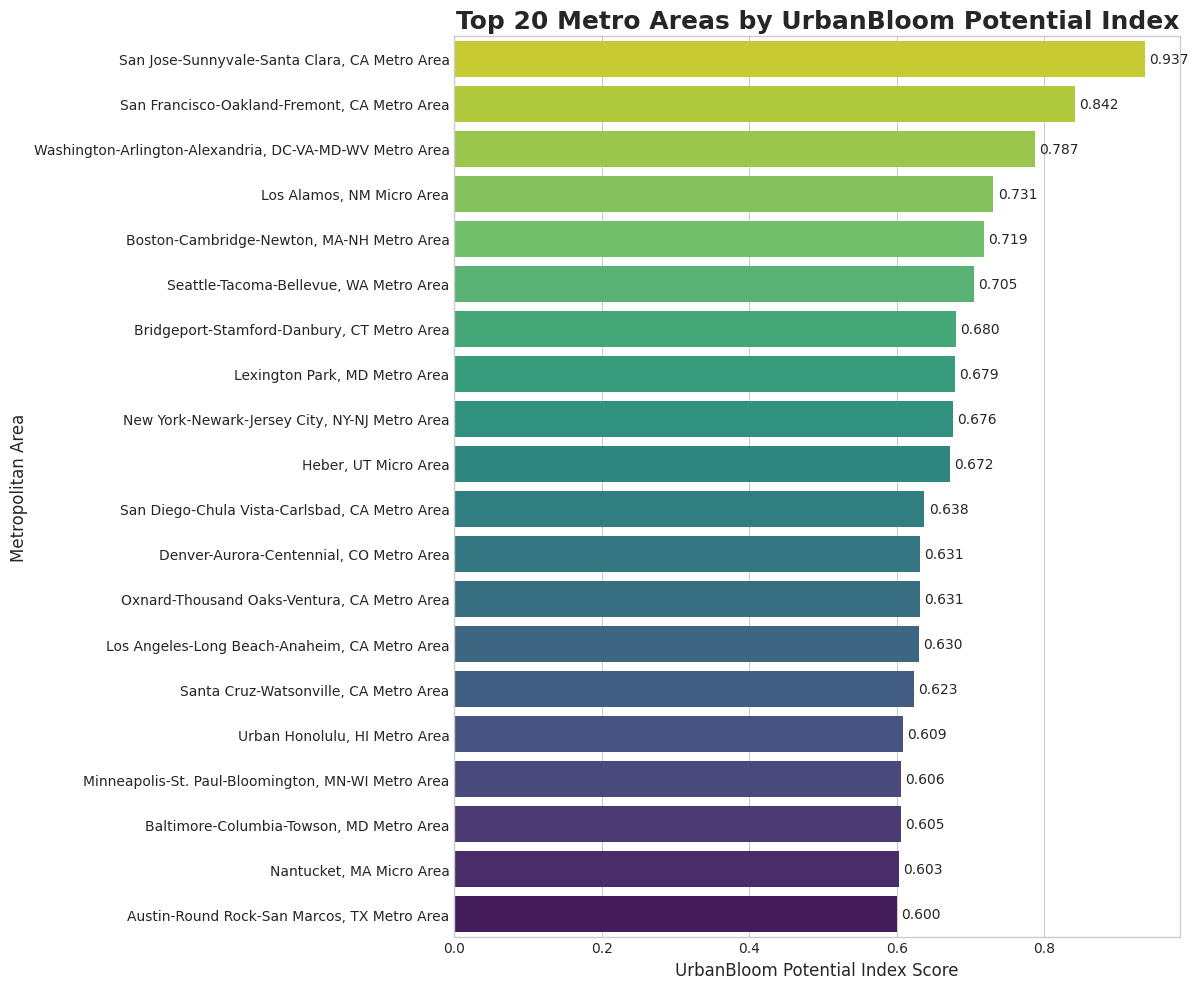

In [19]:
metro_data = load_and_clean_data(FILE_PATH)
metro_data_featured = feature_engineering(metro_data)
ranked_metro_data = calculate_urbanbloom_index(metro_data_featured, WEIGHTS)

print("Top 20 Metro Areas by UrbanBloom Potential Index")
ranked_metro_data_display = ranked_metro_data.reset_index(drop=True)
print(
    ranked_metro_data_display[
        [
            "metro_area",
            "urbanbloom_index",
            "median_income",
            "high_earner_percent",
            "population",
        ]
    ]
    .head(20)
    .to_string()
)

visualize_top_areas(ranked_metro_data)


---
The urban bloom potential index is a custom score that we created to rank different metro areas based on their economic potential and attractiveness for commercial growth.
It's not just a single number from a dataset, instead it's a blend of three factors we believe that are important for identifying the potential of an area.

Three main ingredients to our recipe are:
1. Median Income: This tells us the income of the typical household in an area. It's a strong indicator of the general economic health.
2. High-Earner Percentage: We calculated this metric by adding together the percent of households that earn over $150k a year. This factor measures the
concentration of wealth in an area, which is a good proxy for the potential market for the high-end stuff
3. Population Size (Log-transformation): This represents the total size of the market. We apply a logarithmic transformation to it so that massive cities like New York or Los Angeles don't completely dominate the rankings based on their size. In our opinion, we believe this balances the score, making the comparison between small, medium and large cities more meaningful.

This example takes these three factors and puts them into a 0 to 1 scale, and then combines them using our opinionated weights we defined [x,x,x]. The final result is a single, powerful urban potential index score that ranks every metro area from the highest potential to the lowest.